
# 1 模型过拟合与欠拟合

## 1.1 基础代码

导入工具包，用于模型验证和数据处理。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 可视化 用于创建各种类型的统计图形

from scipy import stats # 用于统计分析

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression  #线性回归
from sklearn.neighbors import KNeighborsRegressor  #K近邻回归
from sklearn.tree import DecisionTreeRegressor     #决策树回归
from sklearn.ensemble import RandomForestRegressor #随机森林回归
from sklearn.svm import SVR  #支持向量回归
import lightgbm as lgb #lightGbm模型

from sklearn.model_selection import train_test_split # 切分数据
from sklearn.metrics import mean_squared_error #评价指标

from sklearn.linear_model import SGDRegressor # 随机梯度下降线性回归

读取数据

In [2]:
train_data_file = "./data/zhengqi_train.txt"
test_data_file =  "./data/zhengqi_test.txt"

train_data = pd.read_csv(train_data_file, sep='\t', encoding='utf-8')
test_data = pd.read_csv(test_data_file, sep='\t', encoding='utf-8')

In [3]:
train_data.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,-0.009,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.015,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,0.183,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384


归一化处理

In [4]:
from sklearn import preprocessing 
# 1读取特征名
features_columns = [col for col in train_data.columns if col not in ['target']]
# 2实例化
min_max_scaler = preprocessing.MinMaxScaler()
# 3训练集fit拟合
min_max_scaler = min_max_scaler.fit(train_data[features_columns])
# 4transform
train_data_scaler = min_max_scaler.transform(train_data[features_columns])
test_data_scaler = min_max_scaler.transform(test_data[features_columns])
# 5转dataframe-设特征列名
train_data_scaler = pd.DataFrame(train_data_scaler)
train_data_scaler.columns = features_columns

test_data_scaler = pd.DataFrame(test_data_scaler)
test_data_scaler.columns = features_columns
# 6添回target列
train_data_scaler['target'] = train_data['target']

PCA处理，特征降维

In [5]:
from sklearn.decomposition import PCA   #主成分分析法

#PCA方法降维
#保留16个主成分
pca = PCA(n_components=16)
new_train_pca_16 = pca.fit_transform(train_data_scaler.iloc[:,0:-1])
new_test_pca_16 = pca.transform(test_data_scaler)
new_train_pca_16 = pd.DataFrame(new_train_pca_16)
new_test_pca_16 = pd.DataFrame(new_test_pca_16)
new_train_pca_16['target'] = train_data_scaler['target']

In [6]:
#采用 pca 保留16维特征的数据
new_train_pca_16 = new_train_pca_16.fillna(0)
train = new_train_pca_16[new_test_pca_16.columns]
target = new_train_pca_16['target']

# 切分数据 训练数据80% 验证数据20%
train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)

## 1.2 欠拟合

In [7]:
clf = SGDRegressor(max_iter=500, tol=1e-2) 
clf.fit(train_data, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data))
score_test = mean_squared_error(test_target, clf.predict(test_data))
print("SGDRegressor train MSE:   ", score_train)
print("SGDRegressor test MSE:   ", score_test)

SGDRegressor train MSE:    0.15181384379355015
SGDRegressor test MSE:    0.15618692974276552


#### 代码解释
SGDRegressor 是一种基于梯度下降的线性回归模型，使用随机梯度下降算法进行参数估计适用于大规模数据集和高维特征。
与传统的批量梯度下降不同，随机梯度下降每次迭代只使用一个样本或一小批样本来更新模型参数，从而减少了内存消耗和计算复杂度。

主要参数：
- loss: 损失函数的类型。可选参数有 'squared_loss'（平方损失，默认）、'huber'（Huber 损失）、'epsilon_insensitive'（ϵ-insensitive 损失）等。
- penalty: 正则化项的类型。可选参数有 'l2'（L2 正则化，默认）、'l1'（L1 正则化）、'elasticnet'（弹性网正则化）等。
- alpha: 正则化项的惩罚力度。默认为0.0001。
- max_iter: 最大迭代次数。默认为1000。
- learning_rate: 学习率的类型或大小。可选参数有 'constant'（恒定学习率）、'optimal'（最优学习率）、'invscaling'（逆标度学习率）等。
- eta0: 初始学习率。默认为0.01。

主要方法：
- fit(X, y): 使用训练数据训练模型。
- predict(X): 对新的输入数据进行预测。
- score(X, y): 返回模型在给定测试数据上的 R^2 分数。


在 SGDRegressor 中，`tol` 是用来控制迭代的停止条件的参数。tol（tolerance）表示容忍度，即当损失函数的变化小于 tol 时，算法会停止迭代。`tol=1e-2` 表示容忍度为 0.01。也就是说，当连续两次迭代的损失函数值之差小于 0.01 时，算法会认为模型已经收敛，并且提前结束迭代，不再继续优化。

## 1.3 过拟合

In [8]:
from sklearn.preprocessing import PolynomialFeatures # 用于进行多项式特征转换。
poly = PolynomialFeatures(5)
train_data_poly = poly.fit_transform(train_data)
test_data_poly = poly.transform(test_data)
clf = SGDRegressor(max_iter=1000, tol=1e-3) 
clf.fit(train_data_poly, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data_poly))
score_test = mean_squared_error(test_target, clf.predict(test_data_poly))
print("SGDRegressor train MSE:   ", score_train)
print("SGDRegressor test MSE:   ", score_test)

SGDRegressor train MSE:    0.13208128238186503
SGDRegressor test MSE:    0.14458655217709998


## 1.4正常拟合

In [9]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3)
train_data_poly = poly.fit_transform(train_data)
test_data_poly = poly.transform(test_data)
clf = SGDRegressor(max_iter=1000, tol=1e-3) 
clf.fit(train_data_poly, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data_poly))
score_test = mean_squared_error(test_target, clf.predict(test_data_poly))
print("SGDRegressor train MSE:   ", score_train)
print("SGDRegressor test MSE:   ", score_test)

SGDRegressor train MSE:    0.13419513490030407
SGDRegressor test MSE:    0.14274747547356217


#### 代码解释
`PolynomialFeatures` 是 scikit-learn（sklearn）库中的一个预处理类，用于生成多项式特征。它可以将原始特征转换为高阶多项式特征，从而扩展特征空间，使模型能够更好地拟合非线性关系。

`PolynomialFeatures` 的主要作用是通过对原始特征进行多项式扩展，引入多项式交互项，从而增加模型的表示能力。对于给定的一组原始特征 x1, x2, ..., xn，`PolynomialFeatures` 将创建由这些特征的所有可能的多项式组合组成的新特征矩阵。

`PolynomialFeatures` 可以生成包括以下几种特征的多项式：

- 指数项：x^d （d 为指定的度数）
- 交叉项：x1^i * x2^j * ... * xn^k （i + j + ... + k 不大于指定的度数）

使用 `PolynomialFeatures` 的步骤如下：

1. 创建 `PolynomialFeatures` 实例，并指定所需的度数。
2. 使用 `fit_transform` 方法将原始特征数据集转换为多项式特征数据集。


# 2 模型正则化

正则化(Regularization)是给需要训练的目标函数加上一些规则（限制），目的是为了防止过拟合。

## 2.1 L2范数正则化
$$
\parallel x\parallel_2=\left(\sum_{i=1}^n\mid x_i\mid^2\right)^{\frac{1}{2}}
$$
又叫欧几里得(Euclid)范数，即向量元素绝对值平方和再进行开方


In [10]:
poly = PolynomialFeatures(3)
train_data_poly = poly.fit_transform(train_data)
test_data_poly = poly.transform(test_data)
clf = SGDRegressor(max_iter=1000, tol=1e-3, penalty= 'L2', alpha=0.0001) 
clf.fit(train_data_poly, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data_poly))
score_test = mean_squared_error(test_target, clf.predict(test_data_poly))
print("SGDRegressor train MSE:   ", score_train)
print("SGDRegressor test MSE:   ", score_test)

SGDRegressor train MSE:    0.13432119501674716
SGDRegressor test MSE:    0.1426776204742311


## 2.2 L1范数正则化
$$
\parallel x\parallel_1=\sum_{i=1}^N\mid x_i\mid 
$$
即向量元素绝对值之和

In [11]:
poly = PolynomialFeatures(3)
train_data_poly = poly.fit_transform(train_data)
test_data_poly = poly.transform(test_data)
clf = SGDRegressor(max_iter=1000, tol=1e-3, penalty= 'L1', alpha=0.00001) 
clf.fit(train_data_poly, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data_poly))
score_test = mean_squared_error(test_target, clf.predict(test_data_poly))
print("SGDRegressor train MSE:   ", score_train)
print("SGDRegressor test MSE:   ", score_test)

SGDRegressor train MSE:    0.133943411262935
SGDRegressor test MSE:    0.14229842600351


## 2.3 ElasticNet 联合 L1和L2范数加权正则化

In [12]:
poly = PolynomialFeatures(3)
train_data_poly = poly.fit_transform(train_data)
test_data_poly = poly.transform(test_data)
clf = SGDRegressor(max_iter=1000, tol=1e-3, penalty= 'elasticnet', l1_ratio=0.9, alpha=0.00001) 
clf.fit(train_data_poly, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data_poly))
score_test = mean_squared_error(test_target, clf.predict(test_data_poly))
print("SGDRegressor train MSE:   ", score_train)
print("SGDRegressor test MSE:   ", score_test)

SGDRegressor train MSE:    0.13408335184518458
SGDRegressor test MSE:    0.1427094727208378


#### 代码解释

1. `elasticnet`：是 `SGDRegressor` 的正则化方法之一。Elastic Net 是一种结合了 L1 正则化（Lasso）和 L2 正则化（Ridge）的线性回归模型正则化方法。通过引入两种正则化项，Elastic Net 可以在处理高维数据时具有特征选择的能力，并且可以克服 Lasso 存在的某些限制。默认情况下，`penalty` 参数被设置为 `'l2'`，即使用 L2 正则化；而设置为 `'elasticnet'` 则表示同时使用 L1 和 L2 正则化。

2. `l1_ratio`：这是 Elastic Net 的混合参数，取值范围为 0 到 1 之间。它控制着 L1 正则化在 Elastic Net 中的比例。当 `l1_ratio` 为 0 时，相当于只使用 L2 正则化，而当 `l1_ratio` 为 1 时，相当于只使用 L1 正则化。在 0 和 1 之间的值表示混合使用两种正则化方法。在给定的示例中，`l1_ratio=0.9` 表示 Elastic Net 正则化主要使用 L1 正则化，较少使用 L2 正则化。

# 3 模型交叉验证

## 3.1 简单交叉验证 Hold-out-menthod

In [13]:
# 简单交叉验证
from sklearn.model_selection import train_test_split # 切分数据
# 切分数据 训练数据80% 验证数据20%
train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)

clf = SGDRegressor(max_iter=1000, tol=1e-3) 
clf.fit(train_data, train_target)
score_train = mean_squared_error(train_target, clf.predict(train_data))
score_test = mean_squared_error(test_target, clf.predict(test_data))
print("SGDRegressor train MSE:   ", score_train)
print("SGDRegressor test MSE:   ", score_test)

SGDRegressor train MSE:    0.1415940546797717
SGDRegressor test MSE:    0.14689229408278165


## 3.2 K折交叉验证 K-fold CV

In [14]:
# 5折交叉验证
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train)):
    train_data,test_data,train_target,test_target = train.values[train_index],train.values[test_index],target[train_index],target[test_index]
    clf = SGDRegressor(max_iter=1000, tol=1e-3) 
    clf.fit(train_data, train_target)
    score_train = mean_squared_error(train_target, clf.predict(train_data))
    score_test = mean_squared_error(test_target, clf.predict(test_data))
    print(k, " 折", "SGDRegressor train MSE:   ", score_train)
    print(k, " 折", "SGDRegressor test MSE:   ", score_test, '\n')  

0  折 SGDRegressor train MSE:    0.1499137658297044
0  折 SGDRegressor test MSE:    0.1065473927176582 

1  折 SGDRegressor train MSE:    0.13357024550007748
1  折 SGDRegressor test MSE:    0.1816447571392363 

2  折 SGDRegressor train MSE:    0.14645981748519107
2  折 SGDRegressor test MSE:    0.13268383953043347 

3  折 SGDRegressor train MSE:    0.1406425883020885
3  折 SGDRegressor test MSE:    0.16206427864796086 

4  折 SGDRegressor train MSE:    0.1387777962461317
4  折 SGDRegressor test MSE:    0.16600911704035512 



#### 代码详解 -`KFold`函数
`KFold` 是 scikit-learn 库中的一个交叉验证方法，用于划分数据集为 k 折，并生成相应的训练集和测试集索引。

语法如下：

```python
sklearn.model_selection.KFold(n_splits, shuffle=False, random_state=None)
```

参数说明：
- `n_splits`：表示将数据集划分为几个折（即 k 值），默认为 5。
- `shuffle`（可选）：表示是否在划分之前对数据进行洗牌，默认为 False。如果设置为 True，则会在划分之前对数据进行洗牌以打乱顺序。
- `random_state`（可选）：表示随机数种子，用于指定洗牌时的随机性。设置相同的随机数种子可以保证每次划分的结果一致。

常用方法和属性：

- `split(X[, y, groups])`：返回一个生成器对象，用于生成每个折的训练集和测试集索引。
- `get_n_splits([X, y, groups])`：返回划分的折数（即 k 值）。

例子：

```python
import numpy as np
from sklearn.model_selection import KFold

# 创建一个 KFold 对象
kf = KFold(n_splits=5)

# 模拟一个数据集
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# 使用 KFold 进行划分
for train_index, test_index in kf.split(data):
    print("Train:", train_index, "Test:", test_index)
    
for train_i,test_i in kf.split(data):
    print(data[train_i],data[test_i])
    print("---------")
```

输出结果：
```
Train: [2 3 4 5 6 7 8 9] Test: [0 1]
Train: [0 1 4 5 6 7 8 9] Test: [2 3]
Train: [0 1 2 3 6 7 8 9] Test: [4 5]
Train: [0 1 2 3 4 5 8 9] Test: [6 7]
Train: [0 1 2 3 4 5 6 7] Test: [8 9]

[3  4  5  6  7  8  9 10] [1 2]
---------
[1  2  5  6  7  8  9 10] [3 4]
---------
[1  2  3  4  7  8  9 10] [5 6]
---------
[1  2  3  4  5  6  9 10] [7 8]
---------
[1  2  3  4  5  6  7  8] [9 10]
---------
```

在这个例子中，我们先创建了一个 `KFold` 对象 `kf`，将数据集 `data` 划分为 5 折交叉验证。然后，在循环中，我们使用 `kf.split(data)` 生成了每个折的训练集索引 `train_index` 和测试集索引 `test_index`。通过打印这些索引，我们可以看到每个折的训练集和测试集索引。

#### 代码详解 -`enumerate`函数
用于将一个可迭代对象转换为一个枚举对象。它返回一个包含索引和元素的元组的迭代器。

语法如下：

```python
enumerate(iterable, start=0)
```

- `iterable`：表示要进行枚举的可迭代对象，可以是列表、元组、字符串、集合等。
- `start`（可选）：表示索引的起始值，默认为 0。

当对一个可迭代对象使用 `enumerate` 函数时，它会返回一个生成器对象，每次迭代都会产生一个元组 `(index, element)`，其中 `index` 是当前元素的索引，从 `start` 开始递增，`element` 是对应的元素。

例子：

```python
fruits = ['apple', 'banana', 'orange']

for index, fruit in enumerate(fruits):
    print(index, fruit)
```

输出结果：
```
0 apple
1 banana
2 orange
```

在例子中，我们使用 `enumerate` 对列表 `fruits` 进行枚举。在每次迭代中，`index` 表示元素的索引，`fruit` 表示对应的水果名称。通过打印 `index` 和 `fruit`，我们可以看到每个元素的索引和对应的水果名称。


## 3.3 留一法 LOO CV

In [15]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
# num = 100
for k, (train_index, test_index) in enumerate(loo.split(train)):
    train_data,test_data,train_target,test_target = train.values[train_index],train.values[test_index],target[train_index],target[test_index]
    clf = SGDRegressor(max_iter=1000, tol=1e-3) 
    clf.fit(train_data, train_target)
    score_train = mean_squared_error(train_target, clf.predict(train_data))
    score_test = mean_squared_error(test_target, clf.predict(test_data))
    print(k, " 个", "SGDRegressor train MSE:   ", score_train)
    print(k, " 个", "SGDRegressor test MSE:   ", score_test, '\n') 
    if k >= 9: # k 大于等于 9时停止迭代
        break

0  个 SGDRegressor train MSE:    0.14154678086730024
0  个 SGDRegressor test MSE:    0.012065815413407692 

1  个 SGDRegressor train MSE:    0.14155310807366145
1  个 SGDRegressor test MSE:    0.1284070906104496 

2  个 SGDRegressor train MSE:    0.1416146883293847
2  个 SGDRegressor test MSE:    0.039426047577402645 

3  个 SGDRegressor train MSE:    0.1415863600282994
3  个 SGDRegressor test MSE:    0.003415838580474376 

4  个 SGDRegressor train MSE:    0.14162529930716214
4  个 SGDRegressor test MSE:    0.011115946286888823 

5  个 SGDRegressor train MSE:    0.1415881641515214
5  个 SGDRegressor test MSE:    0.13704136603528533 

6  个 SGDRegressor train MSE:    0.14157596799992908
6  个 SGDRegressor test MSE:    0.02376598173602542 

7  个 SGDRegressor train MSE:    0.14156227272773078
7  个 SGDRegressor test MSE:    0.0007635271707761818 

8  个 SGDRegressor train MSE:    0.14150680604796795
8  个 SGDRegressor test MSE:    0.08992065000952423 

9  个 SGDRegressor train MSE:    0.1416009075487987
9 

## 3.4 留P法 LPO CV

In [16]:
from sklearn.model_selection import LeavePOut
lpo = LeavePOut(p=10)
# num = 100
for k, (train_index, test_index) in enumerate(lpo.split(train)):
    train_data,test_data,train_target,test_target = train.values[train_index],train.values[test_index],target[train_index],target[test_index]
    clf = SGDRegressor(max_iter=1000, tol=1e-3) 
    clf.fit(train_data, train_target)
    score_train = mean_squared_error(train_target, clf.predict(train_data))
    score_test = mean_squared_error(test_target, clf.predict(test_data))
    print(k, " 10个", "SGDRegressor train MSE:   ", score_train)
    print(k, " 10个", "SGDRegressor test MSE:   ", score_test, '\n') 
    if k >= 9: # k 大于等于 9时停止迭代。
        break

0  10个 SGDRegressor train MSE:    0.14188997841367093
0  10个 SGDRegressor test MSE:    0.04891057028963159 

1  10个 SGDRegressor train MSE:    0.14192614406434934
1  10个 SGDRegressor test MSE:    0.04448387541119956 

2  10个 SGDRegressor train MSE:    0.14204156040593743
2  10个 SGDRegressor test MSE:    0.046971875220281685 

3  10个 SGDRegressor train MSE:    0.14195528728520312
3  10个 SGDRegressor test MSE:    0.05454716320716613 

4  10个 SGDRegressor train MSE:    0.14180044048646773
4  10个 SGDRegressor test MSE:    0.06895314629502325 

5  10个 SGDRegressor train MSE:    0.14202846470130537
5  10个 SGDRegressor test MSE:    0.04503516030552096 

6  10个 SGDRegressor train MSE:    0.1419720126637407
6  10个 SGDRegressor test MSE:    0.04910967979051496 

7  10个 SGDRegressor train MSE:    0.14201217375831207
7  10个 SGDRegressor test MSE:    0.052842266808938575 

8  10个 SGDRegressor train MSE:    0.14190421814074677
8  10个 SGDRegressor test MSE:    0.04721338466918536 

9  10个 SGDRegresso

#### 留P交叉验证 和 K折交叉验证
区别和特点如下：

- 样本划分：留 P 交叉验证按照固定数量 P 的样本划分为测试集，剩余的样本为训练集；K 折交叉验证按照 K 个折的划分将数据集划分为测试集和训练集。
- 迭代次数：留 P 交叉验证的迭代次数取决于样本组合的可能性，通常较大；K 折交叉验证的迭代次数为 K，通常较小。
- 样本重复：留 P 交叉验证每个样本只出现一次作为测试集，可能会有样本重复出现在训练集中；K 折交叉验证每个样本会被分到不同的训练集和测试集中，避免了样本的重复。

# 4模型超参空间及调参

## 4.1穷举网格搜索

In [17]:
# 使用数据训练随机森林模型，采用网格搜索方法调参
from sklearn.model_selection import GridSearchCV # 网格搜索
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # 切分数据
# 切分数据 训练数据80% 验证数据20%
train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)

randomForestRegressor = RandomForestRegressor()
parameters = {
              'n_estimators':[50, 100, 200],
              'max_depth':[1, 2, 3]
        }

clf = GridSearchCV(randomForestRegressor, parameters, cv=5) # cv对train_data使用 5 折交叉验证
clf.fit(train_data, train_target)

score_test = mean_squared_error(test_target, clf.predict(test_data))

print("RandomForestRegressor GridSearchCV test MSE:   ", score_test)
sorted(clf.cv_results_.keys())

RandomForestRegressor GridSearchCV test MSE:    0.2580339125452081


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

#### 代码解释
1. GridSearchCV()

`GridSearchCV` 是一个用于进行网格搜索的类，可以用于参数调优和模型选择。

网格搜索是指将所有可能的参数组合都尝试一遍，并对每组参数进行评估。通过设置参数范围和步长等信息，我们可以控制参数搜索的规模。

下面是使用 `GridSearchCV` 的一般流程：

1. 导入 `GridSearchCV` 类和要使用的模型类。
2. 定义要搜索的参数空间（通常是一个字典）。
3. 创建模型对象。
4. 创建 `GridSearchCV` 对象，传入模型对象、参数空间和其他参数（例如交叉验证的折数）。
5. 使用 `fit` 方法拟合数据，并进行网格搜索和交叉验证。
6. 可以通过 `best_params_` 属性查看最佳参数组合。
7. 可以通过 `best_score_` 属性查看最佳参数组合的得分。
8. 可以通过 `cv_results_` 属性查看所有参数组合的详细结果。
-----
2. `clf.cv_results_.keys()` 

是一个列表，该列表返回字典 `clf.cv_results_` 中所有的键。`clf.cv_results_` 包含了网格搜索过程中的详细结果，包括每组参数组合的得分、训练时间等信息。

通过执行 `clf.cv_results_.keys()`，你将会得到一个列表，其中包含了所有的键。这个列表提供了一个快速查看可用键的方式。

常见的一些键可能包括：

- `'mean_fit_time'`：每个参数组合的平均训练时间。
- `'mean_score_time'`：每个参数组合的平均预测时间。
- `'mean_test_score'`：每个参数组合在交叉验证的测试集上的平均得分。
- `'param_XXX'`：参数 `XXX` 的值（例如，如果有参数 `'n_estimators'`，则会出现 `'param_n_estimators'`）。
- `'rank_test_score'`：每个参数组合在交叉验证中的得分排名。
- `'splitX_test_score'`：第 X 折交叉验证中每个参数组合的得分。

这些指标在模型分析中十分重要，可以查找到整个建模过程中可能的异常

`sorted(clf.cv_results_.keys())` 按字母顺序排序并打印出 clf.cv_results_ 字典中的键.

## 4.2 随机参数优化

In [18]:
# 使用数据训练随机森林模型，采用随机参数优化方法调参
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # 切分数据
# 切分数据 训练数据80% 验证数据20%
train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)

randomForestRegressor = RandomForestRegressor()
parameters = {
              'n_estimators':[50, 100, 200, 300],
              'max_depth':[1, 2, 3, 4, 5]
        }

clf = RandomizedSearchCV(randomForestRegressor, parameters, cv=5)
clf.fit(train_data, train_target)

score_test = mean_squared_error(test_target, clf.predict(test_data))

print("RandomForestRegressor RandomizedSearchCV test MSE:   ", score_test)
sorted(clf.cv_results_.keys())

RandomForestRegressor RandomizedSearchCV test MSE:    0.19466233629207197


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

#### 代码解释
`RandomizedSearchCV` 是一个用于进行随机搜索的类，与 `GridSearchCV` 类似，它也可以用于参数调优和模型选择。

与网格搜索不同的是，随机搜索并不尝试所有可能的参数组合。相反，它从参数空间中随机抽样一组参数，并对每组参数进行评估。通过设置抽样的次数，我们可以控制随机搜索的规模。

下面是使用 `RandomizedSearchCV` 的一般流程：

1. 导入 `RandomizedSearchCV` 类和要使用的模型类。
2. 定义要搜索的参数空间。可以使用分布函数（如均匀分布、正态分布），也可以使用指定的参数列表。
3. 创建模型对象。
4. 创建 `RandomizedSearchCV` 对象，传入模型对象、参数空间和其他参数（例如交叉验证的折数）。
5. 使用 `fit` 方法拟合数据，并进行随机搜索和交叉验证。
6. 可以通过 `best_params_` 属性查看最佳参数组合。
7. 可以通过 `best_score_` 属性查看最佳参数组合的得分。
8. 可以通过 `cv_results_` 属性查看所有参数组合的详细结果。

## 4.3 Lgb 调参

In [19]:
# 使用数据训练LGB模型，采用网格搜索方法调参

clf = lgb.LGBMRegressor(num_leaves=31)

parameters = {
  
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
    
}

clf = GridSearchCV(clf, parameters, cv=5)
clf.fit(train_data, train_target)

print('Best parameters found by grid search are:', clf.best_params_)
score_test = mean_squared_error(test_target, clf.predict(test_data))
print("LGBMRegressor RandomizedSearchCV test MSE:   ", score_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1848, number of used features: 16
[LightGBM] [Info] Start training from score 0.113883
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1848, number of used features: 16
[LightGBM] [Info] Start training from score 0.124781
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1848, number of used features: 16
[LightGBM] [Info] Sta

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1848, number of used features: 16
[LightGBM] [Info] Start training from score 0.129659
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1848, number of used features: 16
[LightGBM] [Info] Start training from score 0.128611
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1848, number of used features: 16
[LightGBM] [Info] Sta

## 4.4 Lgb 线下验证
下面进行数据建模、5折交叉验证、划分数据、对LGB模型进行训练、计算MSE评价性能等流程：

In [20]:
train_data2 = pd.read_csv('./data/zhengqi_train.txt',sep='\t')
test_data2 = pd.read_csv('./data/zhengqi_test.txt',sep='\t')

train_data2_feature = train_data2[test_data2.columns].values
train_data2_target = train_data2['target'].values

In [21]:
# lgb 模型
from sklearn.model_selection  import KFold
import lightgbm as lgb
import numpy as np


# 5折交叉验证
Folds=5
kf = KFold( n_splits=Folds, random_state=100, shuffle=True)
# 记录训练和预测MSE
MSE_DICT = {
    'train_mse':[],
    'test_mse':[]
}

# 线下训练预测
for i, (train_index, test_index) in enumerate(kf.split(train_data2_feature)):
    # lgb树模型
    lgb_reg = lgb.LGBMRegressor(
        learning_rate=0.01,
        max_depth=-1,
        n_estimators=100,
        boosting_type='gbdt',
        random_state=100,
        objective='regression',
    )
   
    # 切分训练集和预测集
    X_train_KFold, X_test_KFold = train_data2_feature[train_index], train_data2_feature[test_index] # 划分出训练集和测试集的特征
    y_train_KFold, y_test_KFold = train_data2_target[train_index], train_data2_target[test_index] # 划分出训练集和测试集的标签
    
    # 训练模型
#     reg.fit(X_train_KFold, y_train_KFold)
    lgb_reg.fit(
            X=X_train_KFold,y=y_train_KFold,
            eval_set=[(X_train_KFold, y_train_KFold),(X_test_KFold, y_test_KFold)],
            eval_names=['Train','Test'],
            # early_stopping_round=100, # 参数已弃用,通过“callbacks”参数传递回调
            # verbose=50, # 参数已弃用,通过“callbacks”参数传递回调
            eval_metric='MSE',# 设置评估指标eval_metric，这里使用均方误差（MSE）
            callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(stopping_rounds=50)]
            
        )


    # 训练集预测 测试集预测
    y_train_KFold_predict = lgb_reg.predict(X_train_KFold,num_iteration=lgb_reg.best_iteration_)
    y_test_KFold_predict = lgb_reg.predict(X_test_KFold,num_iteration=lgb_reg.best_iteration_) 
    
    print('第{}折 训练和预测 训练MSE 预测MSE'.format(i))
    train_mse = mean_squared_error(y_train_KFold_predict, y_train_KFold)
    print('------\n', '训练MSE\n', train_mse, '\n------')
    test_mse = mean_squared_error(y_test_KFold_predict, y_test_KFold)
    print('------\n', '预测MSE\n', test_mse, '\n------\n')
    
    MSE_DICT['train_mse'].append(train_mse)
    MSE_DICT['test_mse'].append(test_mse)
print('------\n', '训练MSE\n', MSE_DICT['train_mse'], '\n', np.mean(MSE_DICT['train_mse']), '\n------')
print('------\n', '预测MSE\n', MSE_DICT['test_mse'], '\n', np.mean(MSE_DICT['test_mse']), '\n------')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8853
[LightGBM] [Info] Number of data points in the train set: 2310, number of used features: 38
[LightGBM] [Info] Start training from score 0.121817
Training until validation scores don't improve for 50 rounds
[100]	Train's l2: 0.223959	Test's l2: 0.247217
Did not meet early stopping. Best iteration is:
[100]	Train's l2: 0.223959	Test's l2: 0.247217
第0折 训练和预测 训练MSE 预测MSE
------
 训练MSE
 0.22395910176815867 
------
------
 预测MSE
 0.24721747302378572 
------

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8853
[LightGBM] [Info] Number of data points in the train set: 2310, number of used features: 38
[LightGBM] [Info] Start training from score 0.113222


 <img src="./img/052_1.png" width = "300" height = "200" alt="" align=center />

#### 代码解释
1. `eval_set` 参数
在训练过程中用于指定评估模型性能的数据集。可以提供一个或多个数据集用于监控模型的性能，并在训练过程中进行早停法（early stopping）等操作。

`eval_set`参数接受一个二维列表，每个元素都是一个包含特征和目标变量的元组。每个元组代表一个数据集，通常由特征数据和对应的目标变量组成。

例如，如果我们有一个训练数据集`(X_train, y_train)`和一个测试数据集`(X_test, y_test)`，可以将它们作为元组传递给`eval_set`参数，如下所示：
```python
eval_set = [(X_train, y_train), (X_test, y_test)]
```

在训练过程中，模型将使用这些数据集来计算训练误差和验证误差，并根据验证误差的变化来决定是否进行早停法。通常情况下，可以通过设置`early_stopping_rounds`参数来定义早停法的逻辑。

-----
2. `eval_names`参数
`eval_names`参数用于为`eval_set`中的数据集指定名称，以便在输出结果中标识每个数据集的名称。

-----
3. `callbacks` 参数

参数输入要求
`callbacks : list of callable, or None, optional (default=None)`
入参是一个list，list中的对象都是callback方法。callbacks在官方文档中主要是四种方法

- early_stopping
  - 停止迭代
  
  `lightgbm.early_stopping(stopping_rounds, first_metric_only=False, verbose=True, min_delta=0.0)`
  
  
  
- log_evaluation
 - 记录迭代过程的指标, 可以在日志中输出
`lightgbm.log_evaluation(period=1, show_stdv=True)`



- record_evaluation(eval_result)
 - 把迭代过程指标记录到输入的空字典中
`lightgbm.record_evaluation(eval_result)` ;eval_result 可以为一个空字典`eval_result = {}`



- `reset_parameter(**kwargs)`
 - 每次迭代更新数据
 
    List of parameters for each boosting round or a callable that calculates the parameter in terms of current number of round
    
    
**示例：**
```python
eval_result = {}
lgb_model = lgb.train(lgb_param, train_set=tr_lgb_dt , valid_sets=[tr_lgb_dt, te_lgb_dt], 
          verbose_eval=20,
          callbacks=[lgb.log_evaluation, lgb.early_stopping(50, first_metric_only=True), lgb.record_evaluation(eval_result)]
          )

```
-----
4. `lgb_reg.predict`中`num_iteration`参数

`num_iteration` 参数用于指定预测时使用的树的迭代次数。在 LightGBM 中，模型训练过程中树的数量是逐步增加的，每一轮都会产生一个新的树。在预测时，可以选择使用模型训练过程中的某个迭代轮数的树来进行预测。

在训练模型时使用了早停功能，即设置了 `early_stopping_round` 参数，那么最佳迭代次数会自动选择并保存在 `lgb_reg.best_iteration_` 属性中。所以可以将其作为 `num_iteration` 参数传递给 `predict()` 方法，以便在预测时使用最佳迭代次数的树。


# 5 学习曲线和验证曲线

## 5.1 学习曲线

<module 'matplotlib.pyplot' from 'D:\\Development\\anaconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

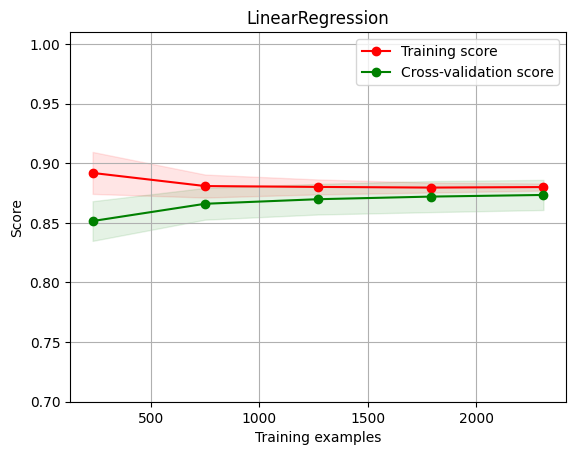

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection 
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X = train_data2[test_data2.columns].values
y = train_data2['target'].values


title = "LinearRegression"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = model_selection.ShuffleSplit(n_splits=100,
                                   test_size=0.2, random_state=0)

estimator = SGDRegressor()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=1)


## 5.2 验证曲线

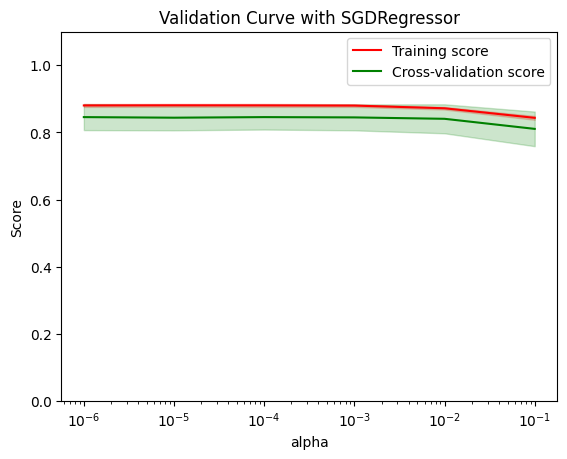

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import validation_curve

X = train_data2[test_data2.columns].values
y = train_data2['target'].values
# max_iter=1000, tol=1e-3, penalty= 'L1', alpha=0.00001

param_range = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
train_scores, test_scores = validation_curve(
    SGDRegressor(max_iter=1000, tol=1e-3, penalty= 'L1'), X, y, param_name="alpha", param_range=param_range,
    cv=10, scoring='r2', n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SGDRegressor")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()